# Benchmark REPS on random MDPs

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pymdp.agent import Agent
import pymdp.maths as maths
import pymdp.utils as utils

In [39]:
def value_iteration(P, R, horizon):
    """Value iteration for computing optimal finite horiozn policy in mdp
    
    Args:
        P (np.array): state transition matrix. size=[state_dim, state_dim, act_dim]
        R (np.array): state reward function. size=[state_dim]
        horizon (int): planning horizon

    Returns:
        q (np.array): optimal Q value function. size=[state_dim, act_dim]
    """
    state_dim = P.shape[0]
    act_dim = P.shape[2]
    R = R.reshape(-1, 1).copy()

    # initialize q value
    q = np.zeros((horizon + 1, state_dim, act_dim))
    q[0] = R
    for h in range(horizon):
        v_next = q[h].max(-1)
        EV = np.einsum("jia, j -> ia", P, v_next)
        q[h+1] = R + EV
    return q[-1]

def pymdp_planner(P, R, horizon, s0, method="REPS", iters=10):
    """Compute the optimal action for initial state s0 using pymdp agent
    """
    assert method in ["VANILLA", "REPS"]
    state_dim = P.shape[0]
    A = np.eye(state_dim) # set observation matrix to diagonal
    B = P.copy()
    C = maths.softmax(R)

    controllable_indices = [0]
    agent = Agent(
        A=A, 
        B=B, 
        C=C,
        control_fac_idx=controllable_indices,
        policy_len=horizon,
        control_algo=method,
        control_iters=iters,
    )
    agent.qs[0] = utils.onehot(s0, state_dim)
    q_pi, efe = agent.infer_policies()
    a = agent.sample_action()
    return a[0], q_pi

In [41]:
# sweep over random mdps of different dimensions
np.random.seed(0)

state_dims = [5, 10, 20]
act_dims = [3, 10, 20]
horizons = [2, 4, 10]
num_samples = 5 # number of samples to evaluate for each config

accuracy = np.zeros((len(horizons), len(state_dims), len(act_dims)))
for s, state_dim in enumerate(state_dims):
    for a, act_dim in enumerate(act_dims):
        for h, horizon in enumerate(horizons):
            P = maths.softmax(
                3 * np.random.normal(size=(state_dim, state_dim, act_dim))
            )
            R = 3 * np.random.normal(size=(state_dim))
            Q = value_iteration(P, R, horizon)

            # sample random initial state
            s0s = np.random.choice(
                np.arange(min(state_dim, num_samples)), 
                size=num_samples, 
                replace=False,
            )
            
            is_correct = np.zeros(len(s0s))
            for i, s0 in enumerate(s0s):
                a_pred, _ = pymdp_planner(P, R, horizon, s0, method="REPS")
                a_true = Q[s0].argmax(-1)
                is_correct[i] = a_pred == a_true
            
            cur_accuracy = is_correct.sum() / len(is_correct)
            accuracy[h, s, a] = cur_accuracy

            print(f"s: {state_dim}, a: {act_dim}, h: {horizon}, acc: {cur_accuracy:.3f}")

s: 5, a: 3, h: 2, acc: 0.800
s: 5, a: 3, h: 4, acc: 0.600
s: 5, a: 3, h: 10, acc: 0.800
s: 5, a: 10, h: 2, acc: 0.000
s: 5, a: 10, h: 4, acc: 0.200
s: 5, a: 10, h: 10, acc: 0.000
s: 5, a: 20, h: 2, acc: 0.000
s: 5, a: 20, h: 4, acc: 0.000
s: 5, a: 20, h: 10, acc: 0.000
s: 10, a: 3, h: 2, acc: 0.400
s: 10, a: 3, h: 4, acc: 0.800
s: 10, a: 3, h: 10, acc: 0.200
s: 10, a: 10, h: 2, acc: 0.000
s: 10, a: 10, h: 4, acc: 0.000
s: 10, a: 10, h: 10, acc: 0.000
s: 10, a: 20, h: 2, acc: 0.000
s: 10, a: 20, h: 4, acc: 0.000
s: 10, a: 20, h: 10, acc: 0.200
s: 20, a: 3, h: 2, acc: 0.200
s: 20, a: 3, h: 4, acc: 0.200
s: 20, a: 3, h: 10, acc: 0.400
s: 20, a: 10, h: 2, acc: 0.000
s: 20, a: 10, h: 4, acc: 0.000
s: 20, a: 10, h: 10, acc: 0.000
s: 20, a: 20, h: 2, acc: 0.000
s: 20, a: 20, h: 4, acc: 0.000
s: 20, a: 20, h: 10, acc: 0.000


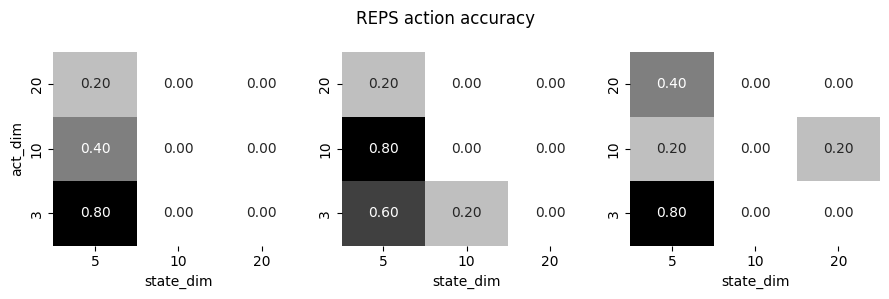

In [55]:
fig, ax = plt.subplots(1, len(horizons), figsize=(9, 3))
for h, horizon in enumerate(horizons):
    sns.heatmap(
        accuracy[h], annot=True, cbar=False, fmt=".2f", cmap="binary", ax=ax[h]
    )
    ax[h].invert_yaxis()
    ax[h].set_xticklabels(state_dims)
    ax[h].set_yticklabels(act_dims)
    ax[h].set_xlabel("state_dim")

ax[0].set_ylabel("act_dim")

plt.suptitle("REPS action accuracy")
plt.tight_layout()
plt.show()